<h1 style="text-align:center;">Miscellaneous</h1>

In [1]:
%%HTML
<style>
    .note {
        background-color: hsl(60, 100%, 80%);
        border: 1px solid transparent;
        border-radius: 5px;
        padding: 5px;
    }
</style>

In [2]:
attributes = {
    'Reddit' : {
        'color' : 'darkred',
        'linestyle' : 'solid',
        'marker': 'tri_down'
    },
    'Spotify': {
        'color': 'green',
        'linestyle': 'dotted',
        'linewidth': '1',
        'marker': 'circle'
    },
    'Snapchat': {
        'color': 'green',
        'linestyle': 'dotted',
        'linewidth': '1',
        'marker': 'circle'
    },
    'Soundcloud': {
        'color': 'orange',
        'linestyle': 'solid',
        'linewidth': '1',
        'marker': 'circle'
    },
    'Viber': {
        'color': 'purple',
        'linestyle': 'dotted',
        'linewidth': '1',
        'marker': 'circle'
    },
    'Tumblr': {
        'color': 'teal',
        'linestyle': 'solid',
        'linewidth': '1',
        'marker': 'circle'
    },
    'Tencent': {
        'color': 'lime',
        'linestyle': 'dotted',
        'linewidth': '1',
        'marker': 'circle'
    }
}

In [3]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import re
import statistics as s
from calendar import monthrange

<h1 style="text-align:center;">Introduction</h1>

Our goal is to detect anomalies in timeseries data, namely user reviews.

## Anomaly Detection

<a href="https://bitbucket.org/rakibulmdalam/time-series-anomaly-detection-framework/src/master/">Timeseries Anomaly Detection Framework</a>


## Data
<h3 style="color:green;">Google Play Store</h3>

User review data comes with the following dimensions:
- Username (string)
- Timestamp (Datetime)
- Rating (integer)
- Likes (integer)
- Review (text)
- Replied to (boolean)

### Granularity

In popular apps reviews can be spaced in time by as little as a few seconds. In less popular apps they can be spaced by more.

Given that each review is timestamped, we can collect averages for any time unit:
- Hour
- Day
- Month
- Year

### Enriching the data

We append columns based on existing columns:

<ul>
    <li>Number of characters in review (integer)</li>
    <li>Number of words in review (integer)</li>
    <li>Average:</li>
    <ul>
        <li>Words</li>
        <li>Chars</li>
        <li>Rating</li>
        <li>Likes</li>
        <li>Reviews</li>
    </ul>
</ul>

Preliminary cleaning of data:
- Remove reviews with less than three words

Via a classification algorithm we give the reviews a category:
- Improvement request
- Bug report
- Other

Similarly, via a classification algorithm we deduce the review sentiment:
- Good
- Bad

Finally, we re-structure the data to fit the anomaly detection framework:

<table style="float:left;border:1px solid gray;">
    <tr>
        <th>Time</th>
        <th>ReviewCount</th>
        <th>Rating</th>
        <th>Words</th>
        <th>Chars</th>
        <th>Good</th>
        <th>Bad</th>
        <th>ImprovementRequest</th>
        <th>BugReport</th>
        <th>Other</th>
    </tr>
    <tr>
        <td>31-01-2020 16:20</td>
        <td>540</td>
        <td>2394</td>
        <td>13200</td>
        <td>32193</td>
        <td>120</td>
        <td>180</td>
        <td>19</td>
        <td>45</td>
        <td>411</td>
    </tr>
</table>

<br>
<br>
<br>
<br>
<br>
<span class="note"><strong>NB:</strong> The framework requires each entry to be equally spaced in time!</span>
<br>
<br>
<span class="note"><strong>NB:</strong> The framework requires first column to be named 'Time' and to have format <strong>%d.%m.%Y %H:%M</strong></span>

<h2 style="color:skyblue">Sources</h2>

- Amazon App Store http://jmcauley.ucsd.edu/data/amazon/
- Google Play Store https://github.com/facundoolano/google-play-scraper

<h2 style="color:purple">Apps</h2>

- Reddit
- Spotify
- Tumblr
- Tencent
- Soundcloud
- Snapchat
- Viber

<h1 style="color:olive;text-align:center;">Function Definitions</h1>

In [4]:
def pie_chart(sizes, labels, title):
    fig, ax = plt.subplots()
    plt.style.use('fast')
    fig=plt.figure(figsize=(12, 8), dpi= 80, facecolor='w', edgecolor='w')
    ax.pie(sizes,
          labels=labels,
          autopct='%1.1f%%',
          shadow=True,
          startangle=90)

    ax.axis('equal')
    ax.set(aspect="equal", title=title)
    plt.show()
    
def multi_lineplot2(props, df, title):
    fig = plt.figure(figsize=(14, 4), dpi= 80, facecolor='w', edgecolor='k')
    plt.style.use('fast')
    
    for key, value in props.items():
        plt.plot(df.index,
                df[key],
                label=key,
                color='%s' % props[key]['color'],
                linestyle='%s' % props[key]['linestyle'],
                linewidth=1)
    plt.title(title)
    plt.legend(loc='lower right')
    
def multi_lineplot(dictionary_appname_properties, dataframe, title):
    fig=plt.figure(figsize=(14, 4), dpi= 80, facecolor='w', edgecolor='k')
    plt.style.use('classic')
    for app, prop in dictionary_appname_properties.items():
        plt.plot(dataframe.index,
                dataframe[app],
                label=app,
                color='%s' % applications[app]['color'],
                linestyle='%s' % applications[app]['linestyle'],
                linewidth=1)
    plt.title(title)
    plt.legend(loc='lower right')
    
def lineplot(xaxis, yaxis, title):
    fig = plt.figure(figsize=(10, 5), dpi = 80, facecolor = 'w', edgecolor = 'k')
    plt.style.use('fast')
    plt.xticks(np.arange(min(yaxis), max(yaxis)+1, 1))
    plt.plot(xaxis,
            yaxis,
            linewidth=1)
    plt.title(title)

def drop_short_reviews(mode, minimum, dataframe):
    indices_to_drop = []
    for index, row in dataframe.iterrows():
        review = row['Review']
        if isinstance(review, str):
            if mode == "word":
                words = re.split(" |-", review)
                if len(words) < minimum:
                    indices_to_drop.append(index)
            else:
                if len(review) < minimum:
                    indices_to_drop.append(index)
    return indices_to_drop

# Returns the daily totals of all dimensions (words, chars, likes, ..)
# for one month as a dictionary with key = "column name", and value =
# list with the sum of column name for each day of the month.
#
# Example: get_monthly(2019, 2, "reddit")
# 
# Return: dictionary (key = "rating",
#                    (value = list)
#
def get_monthly(year, month, app):
    mrange = range(monthrange(year, month)[1])
    year_month = str(year) + "-" + str(month)
    mdf = dfs[app].loc[year_month]
    data = {
        "Day": [],
        "ReviewCount": [],
        "Words": [],
        "Chars": [],
        "Likes": [],
        "Rating": [],
        "Avg_Words": [],
        "Avg_Chars" : [],
        "Avg_Likes": [],
        "Avg_Rating": []
    }
    for n in mrange:
        day = n + 1
        date = year_month + "-" + str(day)
        data["Day"].append(date);
        data["ReviewCount"].append(len(dfs[app].loc[date]))
        data["Words"].append(sum(dfs[app].loc[date]["Words"]))
        data["Chars"].append(sum(dfs[app].loc[date]["Chars"]))
        data["Likes"].append(sum(dfs[app].loc[date]["Likes"]))
        data["Rating"].append(sum(dfs[app].loc[date]["Rating"]))
        data["Avg_Words"].append(round(s.mean(dfs[app].loc[date]["Words"])))
        data["Avg_Chars"].append(round(s.mean(dfs[app].loc[date]["Chars"])))
        data["Avg_Likes"].append(round(s.mean(dfs[app].loc[date]["Likes"])))
        data["Avg_Rating"].append(round(s.mean(dfs[app].loc[date]["Rating"])))
    return data

<h1 style="text-align:center;">Data Pre-processing</h1>

## Structure
We want two __master__ dataframes:
1. __sum_df__: Holds all dimension sums per app (daily, hourly, ..)

2. __avg_df__: Holds all averages of dimensions per app (daily, hourly, ..)

The __key__ is the name of the app, and the __value__ is the app's dataframe.

## Timeframe
All analysis is performed on reviews found in the year __2019__.

In [5]:
dfs = {} # starting dataframes from .csv import

mdfs = {} # DICT ('app_name') > DICT (month #) > DATAFRAME ('col') > LIST (values)
          # mdfs['spotify'][6]['ReviewCount']
          # mdfs['spotify'][6].loc['2019-01-01':'2019-01-10']

<h1 style='font-size: 5em;'>Import</h1>

In [6]:
year = '2019'

apps = ['com.reddit.frontpage',
        'com.spotify.music',
        'com.snapchat.android',
        'com.tumblr',
        'com.viber.voip',
        'com.tencent.mm',
        'com.soundcloud.android',
       'com.whatsapp']

for app in apps:
    key = app.split(".")[1]
    dfs[key] = pd.read_csv("data/gplay_reviews/" + app + ".csv",
                          index_col="Timestamp",
                          parse_dates=True).loc[year]

dfs["soundcloud"].head(3)

/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Username,Rating,Review,Likes,ReplyDate
Timestamp,,,,,
2019-12-31 23:43:16.518000+00:00,Donnell Brown jr,5,Best app for music,0,NaN
2019-12-31 23:42:17.130000+00:00,Jasmine Cole,5,Best music app,0,NaN
2019-12-31 23:26:50.271000+00:00,zeeshan tourist,5,Owsum,0,NaN


# Quick Data Overview

In [7]:
# average of rating in date range
s.mean(dfs['reddit'].loc['2019-01-01':'2019-12-30']['Rating'])

4.38956906161571

In [8]:
type(dfs['reddit'].index)

pandas.core.indexes.datetimes.DatetimeIndex

In [9]:
dfs['reddit'].head(3)

,Username,Rating,Review,Likes,ReplyDate
Timestamp,,,,,
2019-12-31 23:36:53.970000+00:00,Robert Bolton,5,Watch hours of your life vanish with glee,0,NaN
2019-12-31 23:31:41.285000+00:00,Sandra Thomas,5,Reddit is news and humanity! It's a conglomera...,0,NaN
2019-12-31 23:22:35.779000+00:00,Mamali Ph,5,Awesome,0,NaN


In [10]:
# the earliest date of a review for 'reddit' data set
min(dfs['reddit'].index)

Timestamp('2019-01-01 00:03:23.200000+0000', tz='UTC')

In [11]:
# the latest date of a review for 'reddit'
max(dfs["reddit"].index)

Timestamp('2019-12-31 23:36:53.970000+0000', tz='UTC')

In [12]:
# take 24 hours from 12am to 12am
dfs['reddit'].loc['2019-02-02 12:00:00':'2019-02-03 12:00:00']

,Username,Rating,Review,Likes,ReplyDate
Timestamp,,,,,
2019-02-03 11:54:33.539000+00:00,Kelly Spicer,5,"i love reddit!! such positive, fun pages and a...",0,NaN
2019-02-03 11:46:25.994000+00:00,R Roscoe,5,great work day break,0,NaN
2019-02-03 11:38:19.261000+00:00,A Google user,5,I love reddit 10/10 (or 5/5 in this case) that...,0,NaN
2019-02-03 11:28:53.644000+00:00,Seth Trey,5,Really the best sort-of-social network.,0,NaN
2019-02-03 11:19:23.890000+00:00,Barry Johnson,5,Works well,0,NaN
...,...,...,...,...,...
2019-02-02 12:17:48.357000+00:00,Suhaib Shah,4,"Great App, almost everything works perfectly f...",9,NaN
2019-02-02 12:09:48.817000+00:00,Monimonika18,4,So needs a Find function so we could search th...,0,NaN
2019-02-02 12:06:14.346000+00:00,Mani Deep,5,Original Content of memes,0,NaN


In [13]:
review = dfs['reddit'].loc['2019-02-03 11:19:23']['Review'][0]
review

'Works well'

In [14]:
len(review) # Characters

10

In [15]:
word_arr = re.split(" |-", review)
len(word_arr) # Words

2

In [16]:
type(word_arr[0]) == str

True

In [17]:
len(dfs['reddit'])

105105

# Removing Short Reviews

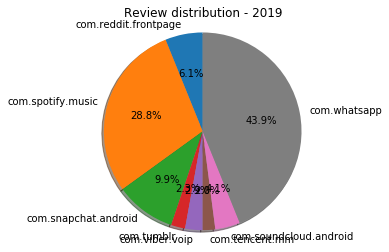

<Figure size 960x640 with 0 Axes>

1714770

In [18]:
sizes = []
for app, dataframe in dfs.items():
    sizes.append(len(dfs[app]))
    
pie_chart(sizes, apps, "Review distribution - 2019")
sum(sizes)

In [19]:
# original length
print(len(dfs["reddit"]),
      len(dfs["spotify"]))

105105 494505


In [20]:
# slow
for app, dataframe in dfs.items():
    indices_to_remove = drop_short_reviews("word", 3, dataframe)
    dfs[app] = dfs[app].drop(indices_to_remove)

In [21]:
# length after clean
print(len(dfs["reddit"]),
      len(dfs["spotify"]))

68868 342013


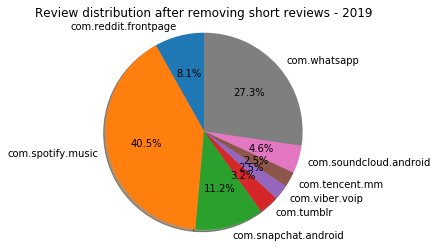

<Figure size 960x640 with 0 Axes>

845482

In [22]:
sizes = []
for app in apps:
    key = app.split(".")[1]
    sizes.append(len(dfs[key]))
    
pie_chart(sizes, apps, "Review distribution after removing short reviews - 2019")
sum(sizes)

In [23]:
dfs["spotify"].head(1)

,Username,Rating,Review,Likes,ReplyDate
Timestamp,,,,,
2019-12-31 23:58:53.673000+00:00,Anayanci Llanes gaxiola,5,It's simply great.,0,NaN


# Adding time related columns

In [24]:
for app, df in dfs.items():
    df['Year'] = df.index.year
    df['Month'] = df.index.month
    df['Weekday Name'] = df.index.weekday_name
    
dfs['spotify'].head(1)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



,Username,Rating,Review,Likes,ReplyDate,Year,Month,Weekday Name
Timestamp,,,,,,,,
2019-12-31 23:58:53.673000+00:00,Anayanci Llanes gaxiola,5,It's simply great.,0,NaN,2019,12,Tuesday


# Adding columns for review length

In [25]:
for app, dataframe in dfs.items():
    review_wordcount = []
    review_charcount = []
    for review in dataframe['Review'].astype('str'):
        review_wordcount.append(len(re.split(" |-", review)))
        review_charcount.append(len(review))
    dfs[app].insert(3, 'Words', review_wordcount)
    dfs[app].insert(4, 'Chars', review_charcount)

In [26]:
dfs["spotify"].head(10)

,Username,Rating,Review,Words,Chars,Likes,ReplyDate,Year,Month,Weekday Name
Timestamp,,,,,,,,,,
2019-12-31 23:58:53.673000+00:00,Anayanci Llanes gaxiola,5,It's simply great.,3,18,0,NaN,2019,12,Tuesday
2019-12-31 23:56:02.302000+00:00,Asish sahoo,1,Worst music app...can't find songs,5,34,0,NaN,2019,12,Tuesday
2019-12-31 23:55:18.947000+00:00,Ian MacLean,2,"Started off as a good app, then after my initi...",32,164,0,NaN,2019,12,Tuesday
2019-12-31 23:54:22.967000+00:00,Belinda Ward,5,Great app with endless music for whatever mood...,10,54,0,NaN,2019,12,Tuesday
2019-12-31 23:52:25.241000+00:00,Satish Kumar,5,Good music app........best app... Number one app,7,48,0,NaN,2019,12,Tuesday
2019-12-31 23:49:50.735000+00:00,T8r t0t,1,If you want to listen to music you want don't ...,50,265,0,NaN,2019,12,Tuesday
2019-12-31 23:48:27.108000+00:00,Dadd J,4,Do enjoy the app had no problems,7,32,0,NaN,2019,12,Tuesday
2019-12-31 23:47:57.460000+00:00,James White,5,Love it. I can listen to the music I want,10,41,0,NaN,2019,12,Tuesday
2019-12-31 23:45:47.794000+00:00,Lisa Moore,4,Love the app way to many adds,7,29,0,NaN,2019,12,Tuesday


# Make monthly dictionary for each app (appname_monthly)
- Key: Month number (1, 12)
- Value: Dictionary with daily totals

In [27]:
for app, dataframe in dfs.items():
    appname = str(app)
    exec(appname + "_monthly = {}")
    for i in range(1,13):
        exec(appname + "_monthly[i] = get_monthly(2019, i, appname)")

StatisticsError: mean requires at least one data point

In [ ]:
for app, attr in attributes.items():
    print(app.lower())

In [ ]:
for app, attr in attributes.items():
    appname = app.lower()
    exec(appname + "_m = {}")
    for i in range(1,13):
        exec("dict_m = " + appname + "_monthly[" + str(i) + "]")
        df = pd.DataFrame.from_dict(dict_m)
        df.index = pd.to_datetime(df['Day'])
        df = df.drop('Day', axis=1)
        exec(appname + "_m[i] = df")

tencent_m[1].head(10)

# Add new monthly dataframes to master dataframe (mdfs)

Conveniently retrieve the daily totals per dimension, per app, with:
- mdfs['app_name'][month_no]

Use .loc to get a range of days of the month:
- mdfs['app_name'][month_no].loc['2019-01-01':'2019-01-05']

Example below

In [ ]:
# replace dfs with the new _m dfs
for app, dataframe in dfs.items():
    exec("mdfs[app] = " + app + "_m")

In [ ]:
type(mdfs['spotify'][1].index)
mdfs['spotify'][1].loc['2019-01-03':'2019-01-12']

In [ ]:
# how many days were there more than 700 reviews?
res = {count for count in mdfs['spotify'][1]['ReviewCount'].tolist() if count > 700}
len(res)

In [ ]:
mdfs['spotify'][1].head(5)

<h1 style="font-size:4em;text-align: center;color:teal;padding-top:50px;padding-bottom:50px;">Plotting Totals</h1>

In [ ]:
x = np.arange(1, monthrange(2019, 8)[1]+1)
y = spotify_m[8]['Words']

fig, ax = plt.subplots(figsize=(10,5))
ax.plot(x, y)
ax.set(xlabel='time (d)',
       ylabel='word count',
       title='Daily Wordcount - Spotify - August')
ax.grid()

plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(18,4))
for i in range(1,13):
    ax.plot(mdfs['spotify'][i]["Words"])
ax.set(xlabel='time (d)', ylabel='word count', title='Daily Wordcount - Spotify - 2019')

plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(18,4))
for i in range(1,13):
    ax.plot(spotify_m[i]["ReviewCount"])
ax.set(xlabel='time (d)', ylabel='review count', title='Daily ReviewCount - Spotify - 2019')
plt.show()

In [ ]:
def grid_5_plot(app, year, month, ylist, color):
    if type(month) == int:
        month_dict = {
            1: "January",
            2: "February",
            3: "March",
            4: "April",
            5: "May",
            6: "June",
            7: "July",
            8: "August",
            9: "September",
            10: "October",
            11: "November",
            12: "December"
        }
    if color == None:
        color = "blue"
        
    x = np.arange(1, monthrange(2019, month)[1]+1)
    mpl.style.use("default")
    fig = plt.figure(figsize=(12,6), constrained_layout=True)
    fig.suptitle(app.title() + " - " + month_dict[month] + " " + str(year),
                 fontsize=18,
                position=(0.5,1.1))
    gs = fig.add_gridspec(3, 2)
    
    y = ylist['ReviewCount']
    ax22 = fig.add_subplot(gs[0, :])
    ax22.plot(x, y, 'o', ls='-', ms=4, markevery=None, color=color)
    ylabel=('Review count')
    
    y = ylist['Words']
    ax00 = fig.add_subplot(gs[2, 0])
    ax00.plot(x, y, color=color)
    ax00.set(title='Wordcount')

    y = ylist['Chars']
    ax10 = fig.add_subplot(gs[2, 1])
    ax10.plot(x, y, color=color)
    ax10.set(title='Character Count')

    y = ylist['Rating']
    ax01 = fig.add_subplot(gs[1,0])
    ax01.plot(x, y, color=color)
    ax01.set_xticks([])
    ax01.set(title='Rating')

    y = ylist['Likes']
    ax11 = fig.add_subplot(gs[1,1])
    ax11.plot(x, y, color=color)
    ax11.scatter(x, y, color=color)
    ax11.set_xticks([])
    ax11.set(title='Likes')
    
def get_year_reviewcount(app):
    fig, ax = plt.subplots(figsize=(18,4))
    for i in range(1,13):
        ax.plot(mdfs[app][i]["ReviewCount"])
    ax.set(xlabel='time (d)',
           ylabel='review count',
           title='Daily ReviewCount - ' + app.title() + ' - 2019')
    plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(18,4))
for i in range(1,13):
    ax.plot(mdfs['viber'][i]["ReviewCount"], color="purple")
    ax.plot(mdfs['soundcloud'][i]["ReviewCount"], color="orange")
ax.set(xlabel='time (d)', ylabel='word count')

plt.show()

In [ ]:
# PLOTS A LOT, SLOW, NB
# for app, df in mdfs.items():
#     get_year_reviewcount(app)
#     for i in range(1,13):
#         grid_5_plot(app, 2019, i, mdfs[app][i], color=attributes[app.title()]['color'])

<h1 style="text-align:center;font-size:4em;">Prepare Data for TSADF</h1>

<h2>Make all rows equally spaced in time</h2>

In [ ]:
mdfs['viber'][3].head(10)

# Or just set time to 00:00

<h2>Change DatetimeIndex to the correct format</h2>

- %d.%m.%Y %H:%M

In [ ]:
list(mdfs['tencent'][1]['ReviewCount'].head(3))

In [ ]:
mdfs['tencent'][1].head(3)

In [ ]:
mdfs['tencent'][1].index

In [ ]:
# takes a list of 'Timestamp' indices
# returns a list of 'String' datetime with 00:00 hrs:mins
def appendZeroTime(indices):
    new_index = [];
    for index in indices:
        index = str(index)
        date = index.split(" ")[0]
        hours = index.split(" ")[1].split(":")[0]
        minutes = index.split(" ")[1].split(":")[1]
        index = date + " 00:00"
        new_index.append(index)
    return new_index
    
print(type(mdfs['tencent']),
        type(mdfs['tencent'][1]),
        type(mdfs['tencent'][1].ReviewCount))

In [ ]:
from datetime import datetime, timedelta

def lp(df, col, title):
    df.index = pd.to_datetime(df.index)
    x = np.arange(df.index[0], df.index[-1], timedelta(days=1)).astype(datetime)
    y = df[col].loc[df.index[0]:df.index[-2]]
    
    fig, ax = plt.subplots(figsize=(10,5))
    ax.plot(x, y)
    ax.set(xlabel='date',
          ylabel=col.lower(),
          title=title)
    ax.grid()
    plt.show()
    
def lp2(df, col, title, vlines):
    df.index = pd.to_datetime(df.index)
    x = np.arange(df.index[0], df.index[-1], timedelta(days=1)).astype(datetime)
    y = df[col].loc[df.index[0]:df.index[-2]]
    
    fig, ax = plt.subplots(figsize=(10,5))
    ax.plot(x, y)
    ax.set(xlabel='date',
          ylabel=col.lower(),
          title=title)
    ax.grid()
    
    for vline in vlines:
        ax.axvline(vline, linewidth=2, color='r')
    
    plt.show()

In [ ]:
# combine the 12 monthly dataframes for each app
# collapse into 1 dataframe with 365 daily totals
def getExportableDf(app):
    c = {
        'index' : [],
        'ReviewCount': [],
        'Words': [],
        'Chars': [],
        'Likes': [],
        'Rating': [],
        'Avg_Words': [],
        'Avg_Chars': [],
        'Avg_Likes': [],
        'Avg_Rating': []
    }
    for i in range(1,13):
        new_index = appendZeroTime(mdfs[app][i].index)
        c['index'] += new_index
        
        for col in mdfs[app][i].columns:
            c[col] += list(mdfs[app][i][col])
            
    exportable = pd.DataFrame.from_dict(c)
    exportable = exportable.set_index('index')
    exportable.index = pd.to_datetime(exportable.index,
                                     format="%Y-%m-%d %H:%S")
    exportable.index = exportable.index.strftime('%d.%m.%Y %H:%S')
    exportable.index.name = 'Time'
    
    return exportable
    
e = getExportableDf('tencent')
e.head(3)



In [ ]:
len(getExportableDf('spotify'))

In [ ]:
e = getExportableDf('spotify')
type(e.index)

# Export

In [ ]:
e.to_csv('spotify_2019.csv', columns = e.columns)

In [ ]:
def printMinAndMax(df):
    print(f"REVIEW \t Ma: {max(df['ReviewCount'])}\t Mi: {min(df['ReviewCount'])}")
    print(f"WORDS \t Ma: {max(df['Words'])}\t Mi: {min(df['Words'])}")
    print(f"CHARS \t Ma: {max(df['Chars'])}\t Mi: {min(df['Chars'])}")
    print(f"LIKES \t Ma: {max(df['Likes'])}\t Mi: {min(df['Likes'])}")
    print(f"RATING \t Ma: {max(df['Rating'])}\t Mi: {min(df['Rating'])}")

In [ ]:
def printHighsLows(app_name):
    df = mdfs[app_name]
    print("\nHighest and lowest daily review count per month for " + app_name + "\n")
    print("MONTH\t\t\t", "HIGH\t\t\t\t\t", "LOW")
    for i in range(1,13):
        vmax = max(df[i].ReviewCount)
        vmin = min(df[i].ReviewCount)
        date_max = df[i].index[df[i]['ReviewCount'] == vmax]
        date_min = df[i].index[df[i]['ReviewCount'] == vmin]
        date_max_d = date_max.strftime("%d")[0]
        date_min_d = date_min.strftime("%d")[0]
        day_name_max = dfs[app_name].loc[date_max[0].strftime("%Y-%m-%d")]['Weekday Name'].values[0]
        day_name_min = dfs[app_name].loc[date_min[0].strftime("%Y-%m-%d")]['Weekday Name'].values[0]
        print(str(i) + "\t\t\t",
              day_name_max + ", " + str(date_max_d), "\t" + str(vmax), "\t\t\t",
              day_name_min + ", " + str(date_min_d), "\t" + str(vmin))

# Crosscheck Anomalies Detected with TSADF

Below, we look into anomalies detected with the framework.

1. Analyze dataset with framework (365 rows, daily totals)
2. Make note of what dates the framework finds anomalies
3. Retrieve the same dates from the dataframe
4. Check max() and min(); see that the framework identifies EV's

The following experiment is done using user reviews for Spotify from the Google Play Store, for the year 2019.

# Nutshell

Below is a linechart of the review count measured throughout 2019 for Spotify.

In [ ]:
get_year_reviewcount('spotify')

Each month has its own color, and we can see some distinct highs and lows in the above linechart.

## What is an anomaly
Even though some of the measured values are _clearly_ higher than other measurements - they're not necessarily anomalies. It could be that these values are part of a natural (__seasonal__) pattern.

Likely, many software development companies have regular __version release cycles__ of e.g., 2 weeks. So the peaks and valleys seen in the chart are natural.

## What is seasonality
To find out, we have to crosscheck our findings -- both through visualization and use of the time series anomaly detection framework -- with _events_ occurring with the company developing the software whose data we are analyzing.

Below, we make note of the extreme values (EVs) recorded each month, pertaining to the spotify user review data. We then look into spotify logs to see if something happened prior to those dates (e.g., new version release).

### Max and min values for review count per month

In [ ]:
printHighsLows('spotify')

## Changelog

Below is a list of dates where a new version was released, taken from __apk4fun.com__

* SoundCloud: https://www.apk4fun.com/history/1563/2/
* Snapchat: https://www.apk4fun.com/history/1299/2/
* Spotify: https://www.apk4fun.com/history/9887/2/

In [ ]:
spotify_versions = [
    '8.5.36.747',
    '8.5.33.831',
    '8.5.32.889',
    '8.5.31.676',
    '8.5.30.579',
    '8.5.29.828',
    '8.5.28.985',
    '8.5.27.957',
    '8.5.25.894',
    '8.5.24.762'
]

spotify_dates = [
    '2019-12-13',
    '2019-11-22',
    '2019-11-11',
    '2019-11-05',
    '2019-10-29',
    '2019-10-22',
    '2019-10-14',
    '2019-10-08',
    '2019-09-30',
    '2019-09-18'
]

spotify_release_dates = {
    12 : ['2019-12-13'],
    11 : ['2019-11-22', '2019-11-11', '2019-11-05'],
    10 : ['2019-10-29', '2019-10-22', '2019-10-22', '2019-10-14', '2019-10-08'],
    9 : ['2019-09-30', '2019-09-18']
}

snapchat_versions = [
    '10.72.5.0',
    '10.72.0.0',
    '10.71.5.0',
    '10.70.5.0',
    '10.70.0.0',
    '10.69.5.0',
    '10.69.0.0',
    '10.68.5.0',
    '10.68.0.0',
    '10.67.5.0'
]
snapchat_dates = [
    '2019-12-17',
    '2019-12-09',
    '2019-12-02',
    '2019-11-19',
    '2019-11-11',
    '2019-11-05',
    '2019-10-30',
    '2019-10-21',
    '2019-10-16',
    '2019-10-03'
]
snapchat_release_dates = {
    12 : ['2019-12-17', '2019-12-09', '2019-12-02'],
    11 : ['2019-11-19', '2019-11-11', '2019-11-05'],
    10: ['2019-10-30', '2019-10-21', '2019-10-16', '2019-10-03']
}

soundcloud_versions = [
    '2019.12.10',
    '2019.11.20',
    '2019.11.11',
    '2019.10.31',
    '2019.10.17',
    '2019.09.30',
    '2019.09.19',
    '2019.09.03',
    '2019.08.23',
    '2019.08.09'
]
soundcloud_dates = [
    '2019-12-10',
    '2019-11-25',
    '2019-11-12',
    '2019-10-31',
    '2019-10-17',
    '2019-09-30',
    '2019-09-19',
    '2019-09-03',
    '2019-08-23',
    '2019-08-12'
]
soundcloud_release_dates = {
    12: ['2019-12-10'],
    11: ['2019-11-25', '2019-11-12'],
    10: ['2019-10-31', '2019-10-17'],
    9: ['2019-09-30', '2019-09-19', '2019-09-03'],
    8: ['2019-08-23', '2019-08-12']
}

release_dates = {
    'spotify' : spotify_release_dates,
    'snapchat' : snapchat_release_dates,
    'soundcloud' : soundcloud_release_dates
}

<div style="padding-top:20px;padding-bottom:20px;text-align:center;">
    <span style="font-size:3em;">Sep/Oct/Nov/Dec - </span><span style="text-decoration:underline;font-size: 3em; color:green;">Spotify</span>
    <h1>Review count <strong style="font-weight: 300;">and release dates</strong></h1>
</div>

In [ ]:
mdfs['spotify'][9].head(1)

# September

In [ ]:
lp2(mdfs['spotify'][9], 'ReviewCount', 'review count and release dates - September 2019', release_dates['spotify'][9])

# October

In [ ]:
lp2(mdfs['spotify'][10], 'ReviewCount', 'review count and release dates - October 2019', release_dates['spotify'][10])

# November

In [ ]:
lp2(mdfs['spotify'][11], 'ReviewCount', 'review count and release dates - November 2019', release_dates['spotify'][11])

# December

In [ ]:
lp2(mdfs['spotify'][12], 'ReviewCount', 'review count and release dates - December 2019', release_dates['spotify'][12])

<div style="padding-top:20px;padding-bottom:20px;text-align:center;">
    <span style="font-size:3em;">Oct/Nov/Dec - </span><span style="text-decoration:underline;font-size: 3em; color:#CCCC00;">Snapchat</span>
    <h1>Review count <strong style="font-weight: 300;">and release dates</strong></h1>
</div>

# October (all dimensions)

In [ ]:
lp2(mdfs['snapchat'][10], 'ReviewCount', 'reviews', release_dates['snapchat'][10])

In [ ]:
lp2(mdfs['snapchat'][10], 'Words', 'words', release_dates['snapchat'][10])

In [ ]:
lp2(mdfs['snapchat'][10], 'Chars', 'characters', release_dates['snapchat'][10])

In [ ]:
lp2(mdfs['snapchat'][10], 'Likes', 'likes', release_dates['snapchat'][10])

In [ ]:
lp2(mdfs['snapchat'][10], 'Rating', 'rating', release_dates['snapchat'][10])

# (all averages)

In [ ]:
lp2(mdfs['snapchat'][10], 'Avg_Words', 'average words', release_dates['snapchat'][10])

In [ ]:
lp2(mdfs['snapchat'][10], 'Avg_Chars', 'average characters', release_dates['snapchat'][10])

In [ ]:
lp2(mdfs['snapchat'][10], 'Avg_Likes', 'average likes', release_dates['snapchat'][10])

In [ ]:
lp2(mdfs['snapchat'][10], 'Avg_Rating', 'average rating', release_dates['snapchat'][10])

# November

In [ ]:
lp2(mdfs['snapchat'][11], 'ReviewCount', 'review count and release dates - October 2019', release_dates['snapchat'][11])

# December

In [ ]:
lp2(mdfs['snapchat'][12], 'ReviewCount', 'review count and release dates - October 2019', release_dates['snapchat'][12])

<div style="padding-top:20px;padding-bottom:20px;text-align:center;">
    <span style="font-size:3em;">Oct/Nov/Dec - </span><span style="text-decoration:underline;font-size: 3em; color:#ff8c00;">SoundCloud</span>
    <h1>Review count <strong style="font-weight: 300;">and release dates</strong></h1>
</div>

# August

In [ ]:
lp2(mdfs['soundcloud'][8], 'ReviewCount', 'review count and release dates - August 2019', release_dates['soundcloud'][8])

# September

In [ ]:
lp2(mdfs['soundcloud'][9], 'ReviewCount', 'review count and release dates - September 2019', release_dates['soundcloud'][9])

# October

In [ ]:
lp2(mdfs['soundcloud'][10], 'ReviewCount', 'review count and release dates - October 2019', release_dates['soundcloud'][10])

# November

In [ ]:
lp2(mdfs['soundcloud'][11], 'ReviewCount', 'review count and release dates - November 2019', release_dates['soundcloud'][11])

# December

In [ ]:
lp2(mdfs['soundcloud'][12], 'ReviewCount', 'review count and release dates - December 2019', release_dates['soundcloud'][12])

<h1 style='font-size:5em;color:#333;'>APK Release History per App </h1>

In this section we consider data collected from multiple sources of APK version history logs. We want to see if software releases can be directly correlated to peaks in user review counts.

Further, we collect the change list for some of the releases to see if we can deduce whether it's a new feature or bug/hot fixes.

<h2>Sources</h2>

* apk4fun.com
* appbrain.com

<h2>Plot Legend</h2>

<ul>
    <li style='color: blue;'>Blue line => Reviews posted</li>
    <li style='color: red;'>Red line => APK version release</li>
</ul>

<h2>Limitations</h2>

Some apps are not at all verbose when it comes to sharing changes from version to version. As such, we only consider those who indeed share details of their changes. This includes:
- Snapchat
- Reddit

In [ ]:
apk_dfs = {}
apps = ['reddit',
       'soundcloud',
       'spotify',
       'tumblr',
       'viber',
       'snapchat']

for app in apps:
    apk_dfs[app] = pd.read_csv("data/apk/" + app + "-apk.csv",
                          index_col="Date",
                          parse_dates=True)

apk_dfs['reddit'].loc['2020-03']

In [ ]:
apk_dfs['snapchat'].loc['2019-05']

# Reddit

In [ ]:
app = 'reddit'
i = 12
lp2(mdfs[app][i],
   'ReviewCount',
   app + ' review count/release date',
   apk_dfs[app].loc['2019-' + str(i)].index)

In [ ]:
apk_dfs['reddit'].loc['2019-12']

In [ ]:
pd.set_option('display.max_colwidth', -1)

In [ ]:
str(apk_dfs['reddit'].loc['2019-12'].Changes)

# Snapchat

In [ ]:
app = 'snapchat'
i = 3
lp2(mdfs[app][i],
   'ReviewCount',
   app + ' review count/release date',
   apk_dfs[app].loc['2019-' + str(i)].index)

In [ ]:
app = 'snapchat'
i = 4
lp2(mdfs[app][i],
   'ReviewCount',
   app + ' review count/release date',
   apk_dfs[app].loc['2019-' + str(i)].index)

In [ ]:
len(apk_dfs['snapchat'].loc['2019-04'].Changes)

In [ ]:
apk_dfs['snapchat'].loc['2019-04'].Changes

<h3>User Reviews with Likes > 25</h3>

In [ ]:
daf = dfs['snapchat'].loc['2019-04-02']
daf[daf.Likes > 25]

In [ ]:
app = 'snapchat'
i = 5
lp2(mdfs[app][i],
   'ReviewCount',
   app + ' review count/release date',
   apk_dfs[app].loc['2019-' + str(i)].index)

In [ ]:
app = 'snapchat'
i = 6
lp2(mdfs[app][i],
   'ReviewCount',
   app + ' review count/release date',
   apk_dfs[app].loc['2019-' + str(i)].index)

In [ ]:
apk_dfs['snapchat'].loc['2019-06'].Changes